In [1]:
from custum_frozen_lake_env import CustumFrozenLakeEnv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Softmax and Log-Sum-Exp

In [2]:
def logsumexp(x, scale = 1):
    x = np.array(x)/scale
    max_x = np.max(x,axis=1,keepdims=True)
    lse_x = max_x[:,0] + np.log(np.exp(x-max_x).sum()) # Numerical Stability
    lse_x = scale*lse_x
    return lse_x

def softmax(x, scale = 1):
    x = np.array(x)/scale
    max_x = np.max(x,axis=1,keepdims=True)
    e_x = np.exp(x - max_x) # Numerical Stability
    p = e_x/np.sum(e_x,axis=1,keepdims=True)
    p = p/np.sum(p,axis=1,keepdims=True)
    return p

def plot_results(policy, value, title="Value Function"):
    plt.figure(num=0)
    plt.imshow(np.reshape(value,(8,8)))
    plt.title(title)  
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if policy[s][0]> 0:
                plt.arrow(j,i,-arr_len,0,color="r",alpha=policy[s][0],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][1]> 0:
                plt.arrow(j,i,0,arr_len,color="r",alpha=policy[s][1],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][2]> 0:
                plt.arrow(j,i,arr_len,0,color="r",alpha=policy[s][2],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
            if policy[s][3]> 0:
                plt.arrow(j,i,0,-arr_len,color="r",alpha=policy[s][3],width=0.01,head_width=0.5,head_length=0.1,overhang=1)
    plt.show()

# Define Frozen Lake Environment

In [3]:
env = CustumFrozenLakeEnv(map_name="8x8")

obs_space = env.observation_space
n_state = obs_space.n
print('Observation space')
print("Total {} states".format(n_state))

act_space = env.action_space
n_act = act_space.n
print('Action space')
print("Total {} actions".format(n_act))

Observation space
Total 64 states
Action space
Total 4 actions


# Train Expert's Policy
---
## Soft Value Iteration
### Soft Bellman backup operator
### $V_{k+1}(s)=\alpha \log\left(\sum_{a}\exp\left(\frac{\sum_{s'}\left[r(s,a,s')+V_{k}(s')\right]P(s'|s,a)}{\alpha}\right)\right)$
### Policy can be computed by softmax distribution of state action value
### $Q(s,a)=\sum_{s'}\left[r(s,a,s')+V_{k}(s')\right]P(s'|s,a)$
### $\pi(a|s) = \frac{\exp(Q(s,a))}{\sum_{a'}\exp(Q(s,a'))}$
## State action visitation
### $\rho_{\pi}(s,a) = \mathbb{E}[\sum_{t=0}^{\infty}\gamma^t\mathbb{1}(s_t=s,a_t=a)|\pi] = \sum_{t=0}^{\infty}\gamma^tP_{\pi}(s_t=s,a_t=a) $
### $= \sum_{t=0}^{\infty}\gamma^tP_{\pi}(a_t=a|s_t=s)P_{\pi}(s_t=s) = \pi(a|s)\sum_{t=0}^{\infty}\gamma^tP_{\pi}(s_t=s) = \pi(a|s)\rho_{\pi}(s)$
## State visitation
### $\rho_{\pi}(s) = \mathbb{E}[\sum_{t=0}^{\infty}\gamma^t\mathbb{1}(s_t=s)|\pi] = \sum_{t=0}^{\infty}\gamma^tP_{\pi}(s_t=s)$
### $= P_{\pi}(s_0=s)+\gamma\sum_{t=1}^{\infty}\gamma^{t-1}\sum_{s',a'}P_{\pi}(s_t=s|s_{t-1}=s',a_{t-1}=a')P_{\pi}(s_{t-1}=s',a_{t-1}=a')$
### $= d(s)+\gamma\sum_{s',a'}P(s|s',a')\rho_{\pi}(s',a')$
## Bellman flow equation
### $\rho_{\pi}(s)= d(s) + \gamma\sum_{s',a'}P(s|s',a')\rho_{\pi}(s')\pi(a'|s')$
### It is contraction!!


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


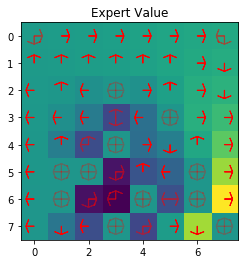

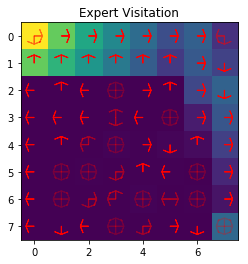

In [4]:
def policy_evaluation(env, policy, gamma = 0.99, epsilon = 1e-6, scale=1e-5):
    
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                r[s][a][next_s]=reward
                
    # Random initial
    v = np.random.uniform(size=(n_state,))
    
    while True:
        v_prime = np.sum(policy*np.sum((r+gamma*np.tile(v[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2),axis=1)
        dist = np.max(np.abs(v-v_prime))
        v = v_prime
        if dist < epsilon:
            break
    return v

def soft_value_iteration(env,rewards=None,gamma=0.99,epsilon=1e-6,scale=1e-5):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    r = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
                if rewards is None:
                    r[s][a][next_s]=reward
                else:
                    r[s][a][next_s]=rewards[s][a][next_s]

    value = np.random.uniform(size=(n_state,))
    
    while True: 
        q = np.sum((r+gamma*np.tile(value[np.newaxis,np.newaxis,:],reps=(n_state,n_act,1)))*P,axis=2)
        v_prime = logsumexp(q,scale=scale) # Log Sum Exp, Soft Bellman operator
        dist = np.max(np.abs(value-v_prime)) # Measure the distance
        value = v_prime
        if dist < epsilon:
            break

    policy = softmax(q,scale=scale)
    return policy, value

def get_visitation(env,policy,gamma=0.99,epsilon=1e-6):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
    
    d = np.zeros((n_state,))
    d[0] = 1
    
    mu_s = np.zeros((n_state,))
    mu_s[0] = 1
    while True:
        mu_sa = policy*np.tile(mu_s[:,np.newaxis],reps=(1,n_act))
        mu_prime = d + gamma*np.sum(np.sum(P*np.tile(mu_sa[:,:,np.newaxis],reps=(1,1,n_state)),axis=0),axis=0) # Bellman Flow Equation
        dist = np.max(np.abs(mu_s-mu_prime))
        mu_s = mu_prime
        if dist < epsilon:
            break

    mu_sa = policy*np.tile(mu_s[:,np.newaxis],reps=(1,n_act))
    
    return mu_s, mu_sa

if __name__=='__main__': 
    gamma = 0.95
    expert_policy, _ = soft_value_iteration(env,gamma=gamma)
    expert_value = policy_evaluation(env,expert_policy,gamma=gamma)
    expert_mu_s, expert_mu_sa = get_visitation(env,expert_policy,gamma=gamma)
    
    env.reset()
    env.render()
    plot_results(expert_policy, expert_value, title="Expert Value")
    plot_results(expert_policy, expert_mu_s, title="Expert Visitation")

# Sample Demonstrations from Experts

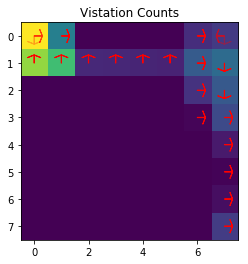

In [9]:
obs_space = env.observation_space
n_state = obs_space.n
act_space = env.action_space
n_act = act_space.n

n_episode = 1
mu_sa_hat = np.zeros((n_state,n_act))
for episode in range(n_episode):
    state = env.reset()
    t = 0
    done = False
    while not done:
        t += 1
        action = np.random.choice(n_act,p=expert_policy[state])
        next_state, reward, done, info = env.step(action)
        mu_sa_hat[state][action] += gamma**t
        state = next_state
    mu_sa_hat[state][action] += gamma**t/(1-gamma)
mu_sa_hat = mu_sa_hat/n_episode
mu_s_hat = np.sum(mu_sa_hat,axis=1)
plot_results(mu_sa_hat/np.sum(mu_sa_hat+1e-10,axis=1,keepdims=True), mu_s_hat, title="Vistation Counts")

# Maximum Entropy Inverse Reinforcement Learning
## Step 1
### Initialize rewards parameter $\theta^{0}$
### In this example, $\theta_{sas'}^{0} = r(s,a,s')$
### We directly find the rewards $r(s,a,s')$ of each transition state, action, and next state
### Since there are 64 states and 4 actions, our optimization variable is $64\times4\times64$

## Step 2
### Solve soft MDP using soft value iteration under $\theta^{i}$
### Obtain softmax policy from value
### Find state action visitation $\rho_{\pi}(s,a)$

## Step 3
### Find the gradient of $\theta$ as follows:
### $ d\theta_{sas'} = P(s'|s,a)(\rho_{E}(s,a) - \rho_{\pi}(s,a))$
### Update parameters
### $ \theta_{sas'} \leftarrow \theta_{sas'} + \alpha d\theta_{sas'}$

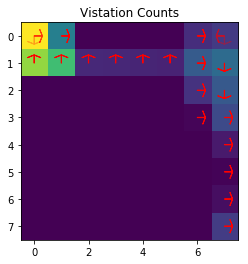

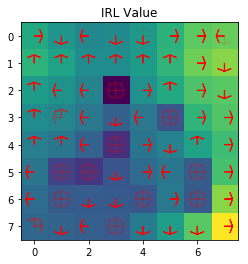

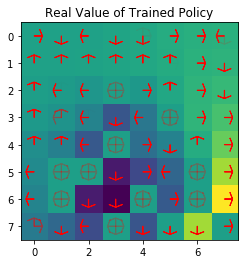

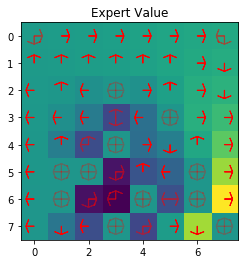

In [11]:
def maxentirl(env,mu_sa_hat,gamma=0.99,learning_rate=1e-3, n_iteration=10):
    obs_space = env.observation_space
    n_state = obs_space.n
    act_space = env.action_space
    n_act = act_space.n
    
    P = np.zeros((n_state,n_act,n_state))
    for s in env.unwrapped.P.keys(): # For all states s, update v(s)
        for a in env.unwrapped.P[s].keys(): # For all actions a
            for prob, next_s, reward, done in env.unwrapped.P[s][a]: # For all possible transitions (s,a,s')
                P[s][a][next_s]=prob
    
    r = np.zeros((n_state,n_act,n_state))
    for iteration in range(n_iteration):
        policy, _ = soft_value_iteration(env,rewards=r,gamma=gamma) # Solve soft MDP
        _, mu_sa = get_visitation(env,policy,gamma=gamma) # Find visitation

        grad = P*np.tile((mu_sa_hat - mu_sa)[:,:,np.newaxis],reps=(1,1,n_state)) # Compute the gradient

        r+=learning_rate*grad # Update rewards function
        
    policy, value = soft_value_iteration(env,rewards=r,gamma=gamma)
    return r, value, policy
    
if __name__=='__main__': 
    irl_r, irl_value, trained_policy = maxentirl(env,mu_sa_hat,gamma=gamma)
    trained_value = policy_evaluation(env,trained_policy,gamma=gamma)
    plot_results(mu_sa_hat/np.sum(mu_sa_hat+1e-10,axis=1,keepdims=True), mu_s_hat, title="Vistation Counts")
    plot_results(trained_policy, irl_value, title="IRL Value")
    plot_results(trained_policy, trained_value, title="Real Value of Trained Policy")
    plot_results(expert_policy, expert_value, title="Expert Value")